# 电子商务客户细分以及商品推荐
目的：细分客户；对每类客户对产品的需求进行细分并推荐

In [199]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import datetime, nltk
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from wordcloud import WordCloud
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import cross_val_score
import  warnings
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


In [2]:
warnings.filterwarnings('ignore')

In [3]:
data=pd.read_csv(r'C:\Users\Administrator\Desktop\data.csv',encoding='gbk')

In [4]:
data.columns = ['订单编号', '库存代码', '描述', '数量', '订单日期', '单价', '客户ID']

In [5]:
data.head()

,订单编号,库存代码,描述,数量,订单日期,单价,客户ID
0,559518,21989,PACK OF 20 SKULL PAPER NAPKINS,6,07/08/2011 16:11,1.63,NaN
1,559518,22055,MINI CAKE STAND HANGING STRAWBERY,1,07/08/2011 16:11,3.29,NaN
2,559518,22179,SET 10 NIGHT OWL LIGHTS,1,07/08/2011 16:11,13.29,NaN
3,559518,22297,HEART IVORY TRELLIS SMALL,1,07/08/2011 16:11,2.46,NaN
4,559518,22352,LUNCH BOX WITH CUTLERY RETROSPOT,1,07/08/2011 16:11,4.96,NaN


# 数据清洗

In [6]:
data.isnull().mean()#查看一下缺失值的比例

订单编号    0.000000
库存代码    0.000000
描述      0.001763
数量      0.000000
订单日期    0.000000
单价      0.000000
客户ID    0.215508
dtype: float64

In [7]:
#删除所由的缺失值
data=data.dropna()

In [8]:
#删除所由的重复值
data=data.drop_duplicates()

In [9]:
data.describe()

,数量,单价,客户ID
count,220177.000000,220177.000000,220177.000000
mean,11.986556,3.232984,15282.479151
std,248.945726,29.278405,1701.276075
min,-80995.000000,0.000000,12347.000000
25%,2.000000,1.250000,13991.000000
50%,5.000000,1.690000,15144.000000
75%,12.000000,3.750000,16764.000000
max,80995.000000,4287.630000,18287.000000


可以看到数量里面有负数这显然不合理

In [10]:
data[data['数量'].apply(lambda x:x<0)]

,订单编号,库存代码,描述,数量,订单日期,单价,客户ID
279,C559530,22655,VINTAGE RED KITCHEN CABINET,-1,07/10/2011 12:04,125.00,14808.0
285,C559531,22846,BREAD BIN DINER STYLE RED,-1,07/10/2011 12:07,16.95,14808.0
286,C559533,20914,SET/5 RED RETROSPOT LID GLASS BOWLS,-1,07/10/2011 12:10,2.95,17126.0
287,C559534,47594B,SCOTTIES DESIGN WASHBAG,-2,07/10/2011 12:11,1.95,16283.0
469,C559540,21850,BLUE DIAMANTE PEN IN GIFT BOX,-36,07/10/2011 12:39,4.25,18024.0
...,...,...,...,...,...,...,...
283249,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/09/2011 09:57,0.83,14397.0
284341,C581499,M,Manual,-1,12/09/2011 10:28,224.69,15498.0
284515,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/09/2011 11:57,10.95,15311.0
284516,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/09/2011 11:58,1.25,17315.0


可以看出有相当一部分订单都是负数,而这些订单都是被取消的订单,我们将取消的订单和未被取消的订单分开

In [11]:
data_no=data[data['订单编号'].apply(lambda x:'C' in x)]
data_no.head()

,订单编号,库存代码,描述,数量,订单日期,单价,客户ID
279,C559530,22655,VINTAGE RED KITCHEN CABINET,-1,07/10/2011 12:04,125.00,14808.0
285,C559531,22846,BREAD BIN DINER STYLE RED,-1,07/10/2011 12:07,16.95,14808.0
286,C559533,20914,SET/5 RED RETROSPOT LID GLASS BOWLS,-1,07/10/2011 12:10,2.95,17126.0
287,C559534,47594B,SCOTTIES DESIGN WASHBAG,-2,07/10/2011 12:11,1.95,16283.0
469,C559540,21850,BLUE DIAMANTE PEN IN GIFT BOX,-36,07/10/2011 12:39,4.25,18024.0


然后将原始数据中的被取消的订单删除

In [12]:
data=data[data['数量'].apply(lambda x:x>0)]

In [13]:
data.describe()

,数量,单价,客户ID
count,215717.000000,215717.000000,215717.000000
mean,12.892544,2.999510,15288.557564
std,180.994981,20.957499,1700.978127
min,1.000000,0.000000,12347.000000
25%,2.000000,1.060000,13995.000000
50%,5.000000,1.690000,15150.000000
75%,12.000000,3.750000,16764.000000
max,80995.000000,4161.060000,18287.000000


发现没有负数了，说明数量为负的都是被取消的订单

# 描述性分析

In [14]:
data.head()

,订单编号,库存代码,描述,数量,订单日期,单价,客户ID
19,559519,22662,LUNCH BAG DOLLY GIRL DESIGN,150,07/08/2011 16:17,1.45,17353.0
20,559519,22383,LUNCH BAG SUKI DESIGN,150,07/08/2011 16:17,1.45,17353.0
21,559519,20728,LUNCH BAG CARS BLUE,150,07/08/2011 16:17,1.45,17353.0
22,559519,22382,LUNCH BAG SPACEBOY DESIGN,150,07/08/2011 16:17,1.45,17353.0
98,559523,23164,REGENCY CAKE SLICE,1,07/08/2011 17:19,4.95,13955.0


产品，交易，客户分析

其中一些用户只购买意见商品因此只有一个订单，而另一些用户却购买了大量的订单因此这些用户拥有多条订单

查看一下总的产品，交易和客户的类型一共有多少；而一条订单也可能有多个商品购买记录

In [15]:
pd.DataFrame([{'产品': len(np.unique(data['库存代码']).tolist()),    
               '交易': len(np.unique(data['订单编号']).tolist()),
               '客户': len(np.unique(data['客户ID']).tolist()),  
              }], 
             columns = ['产品', '交易', '客户'], 
             index = ['数量'])

,产品,交易,客户
数量,3174,9382,3313


查看不同用户不同订单分别有多少条记录

In [16]:
data_per_basket=data.groupby(by=['客户ID','订单编号'],as_index=False)['订单日期'].count()
data_per_basket=data_per_basket.rename(columns={'订单日期':'产品数量'})
data_per_basket.sort_values('客户ID')

,客户ID,订单编号,产品数量
0,12347.0,562032,22
1,12347.0,573511,47
2,12347.0,581180,11
3,12348.0,568172,3
4,12349.0,577609,73
...,...,...,...
9371,18283.0,560025,54
9374,18283.0,573093,38
9379,18283.0,580872,50
9380,18287.0,570715,38


取消订单分析

将数量由-1改成1

In [17]:
data_no['数量']=data_no['数量'].apply(lambda x:x*(-1))
data_no

,订单编号,库存代码,描述,数量,订单日期,单价,客户ID
279,C559530,22655,VINTAGE RED KITCHEN CABINET,1,07/10/2011 12:04,125.00,14808.0
285,C559531,22846,BREAD BIN DINER STYLE RED,1,07/10/2011 12:07,16.95,14808.0
286,C559533,20914,SET/5 RED RETROSPOT LID GLASS BOWLS,1,07/10/2011 12:10,2.95,17126.0
287,C559534,47594B,SCOTTIES DESIGN WASHBAG,2,07/10/2011 12:11,1.95,16283.0
469,C559540,21850,BLUE DIAMANTE PEN IN GIFT BOX,36,07/10/2011 12:39,4.25,18024.0
...,...,...,...,...,...,...,...
283249,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,11,12/09/2011 09:57,0.83,14397.0
284341,C581499,M,Manual,1,12/09/2011 10:28,224.69,15498.0
284515,C581568,21258,VICTORIAN SEWING BOX LARGE,5,12/09/2011 11:57,10.95,15311.0
284516,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,1,12/09/2011 11:58,1.25,17315.0


In [18]:
data_no_per_basket=data_no.groupby(by=['客户ID','订单编号']).agg(取消订单量=('数量','count')).reset_index()
n1=data_no_per_basket.shape[0]
n2=data_per_basket.shape[0]+n1
percentage = (n1/n2)*100
print('取消订单数量: {}/{} ({:.2f}%) '.format(n1, n2, percentage))

取消订单数量: 1686/11068 (15.23%) 


可以看出被取消的订单占总订单的15.23%,占的比重较高

In [19]:
n3=(data['数量']*data['单价']).sum()#没有被取消的订单的总获利
n4=(data_no['数量']*data_no['单价']).sum()
percentage_=(n4/(n3+n4))*100
print('取消订单数量: {}/{} ({:.2f}%) '.format(n3, n2+n3, percentage_))

取消订单数量: 4760348.353/4771416.353 (6.68%) 


可以看出被取消的订单的总价值占所有订单总价值的6.68%,相对较低

购物车价格分析

数据集中的每一条记录都表示一种产品的价格。而一条订单可以被分成几条记录。因此需要将一条订单中所有价格汇总求和，得到每一个订单总价。

In [20]:
data['总价']=data['数量']*data['单价']
data.head()

,订单编号,库存代码,描述,数量,订单日期,单价,客户ID,总价
19,559519,22662,LUNCH BAG DOLLY GIRL DESIGN,150,07/08/2011 16:17,1.45,17353.0,217.50
20,559519,22383,LUNCH BAG SUKI DESIGN,150,07/08/2011 16:17,1.45,17353.0,217.50
21,559519,20728,LUNCH BAG CARS BLUE,150,07/08/2011 16:17,1.45,17353.0,217.50
22,559519,22382,LUNCH BAG SPACEBOY DESIGN,150,07/08/2011 16:17,1.45,17353.0,217.50
98,559523,23164,REGENCY CAKE SLICE,1,07/08/2011 17:19,4.95,13955.0,4.95


In [21]:
#购物车总价
basket_price=data.groupby(by=['客户ID','订单编号']).agg(购物车价格=('总价','sum')).reset_index()
basket_price.head()

,客户ID,订单编号,购物车价格
0,12347.0,562032,584.91
1,12347.0,573511,1294.32
2,12347.0,581180,224.82
3,12348.0,568172,310.00
4,12349.0,577609,1757.55


处理订单日期,将订单日期转换为整数类型，聚合后求平均值，在转换为日期型

In [22]:

data['订单日期']=pd.to_datetime(data['订单日期'])
data['订单日期_int']=data['订单日期'].astype('int64')
temp=data.groupby(by=['客户ID','订单编号'],as_index=False)['订单日期_int'].mean()
data.drop('订单日期_int', axis = 1, inplace = True)
basket_price.loc[:, '订单日期'] = pd.to_datetime(temp['订单日期_int'])

取购物车价格大于0的订单

In [23]:
basket_price=basket_price[basket_price['购物车价格']>0]

In [24]:
basket_price.describe([0.01,0.2,0.4,0.6,0.8,1]).T

,count,mean,std,min,1%,20%,40%,50%,60%,80%,100%,max
客户ID,9379.0,15254.137328,1724.483327,12347.00,12421.0000,13468.000,14646.00,15152.00,15805.000,17070.400,18287.0,18287.0
购物车价格,9379.0,507.553935,2006.200974,0.38,9.0078,138.152,249.48,307.19,353.012,568.226,168469.6,168469.6


In [25]:
bins_1=[0, 50, 100, 200, 500, 1000, 5000, 50000]
labels=['0-50','50-100','100-200','200-500','500-1000','1000-5000','5000-50000']
basket_price['价格区间']=pd.cut(basket_price['购物车价格'],bins=bins_1,labels=labels)

([<matplotlib.patches.Wedge at 0x1f466a7e608>,
 [Text(0.10548090464312998, 2.1228467677876517, '0-50'),
  Text(0.32915042587611176, 2.701236112403168, '50-100'),
  Text(1.4375096323006429, 3.486483244306087, '100-200'),
  Text(3.475341627353769, 1.3890797745843784, '200-500'),
  Text(0.8679249867235788, 0.3484969274487364, '500-1000'),
  Text(0.1350559962180251, 1.3487944323587682, '1000-5000'),
  Text(0.07540892980621217, 1.7624415041855324, '5000-50000')],
 [Text(0.6212041075778292, 2.0245890558522794, '6.0%'),
  Text(0.7768002962616427, 2.426946860802204, '5.5%'),
  Text(1.5478327876874038, 2.973205735169452, '20.2%'),
  Text(2.9654550451156654, 1.5141424518847848, '44.1%'),
  Text(1.1515999907642285, 0.7902587321382513, '16.4%'),
  Text(0.6417780843255825, 1.4861178659887082, '7.0%'),
  Text(0.6002844729086692, 1.7738723507377616, '0.7%')])

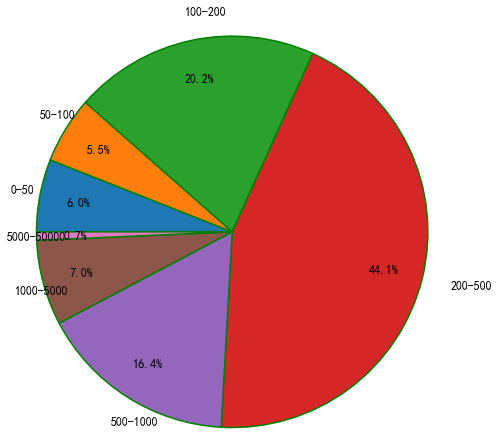

In [26]:
fig=plt.figure(figsize=(10,6))
basket_price_sum=basket_price.groupby(by=['价格区间']).agg(购物车总价=('购物车价格','count'))
plt.pie(x = basket_price_sum, # 绘图数据
        labels=basket_price_sum.index, # 添加教育水平标签
        autopct='%.1f%%', # 设置百分比的格式，这里保留一位小数
        pctdistance=0.8,  # 设置百分比标签与圆心的距离
        labeldistance = 1.15, # 设置教育水平标签与圆心的距离
        startangle = 180, # 设置饼图的初始角度
        radius = 1.5, # 设置饼图的半径
        counterclock = False, # 是否逆时针，这里设置为顺时针方向
        wedgeprops = {'linewidth': 1.5, 'edgecolor':'green'},# 设置饼图内外边界的属性值
        textprops = {'fontsize':12, 'color':'k'}, # 设置文本标签的属性值
        center = (1.8,1.8) )#是否显示饼图的图框，这里设置显示

可以看出绝大多数订单价格较高，有超过百分之60的订单价格大于200英镑

产品分类

In [27]:
data_describe=pd.DataFrame(np.unique(data['描述']).tolist()).rename(columns = {0:'描述'})

#提取产品描述中出现的名称(适当的，常见的)
#对于每个名称，提取单词的根，并聚合与这个特定根相关的名称集
#每个根出现在数据集中的次数计数
#当几个单词被列出为同一个词根时，我认为与这个词根相关的关键字是最短的名字(当有单数/复数变体时，系统地选择单数)

In [28]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = '描述'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # 收集单词或词根
    keywords_select = dict()  # 关联: 词根<->关键字
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:   # 循环获取数据集中每条信息
        if pd.isnull(s): continue  # 过滤是否是空值
        lines = s.lower()          # 小写转换
        tokenized = nltk.word_tokenize(lines)  # 分词
        # 筛选名词词性
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t) # 词根提取
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("变量中关键字'{}'的数量 : {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [29]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(data_describe)

变量中关键字'描述'的数量 : 1343


In [30]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

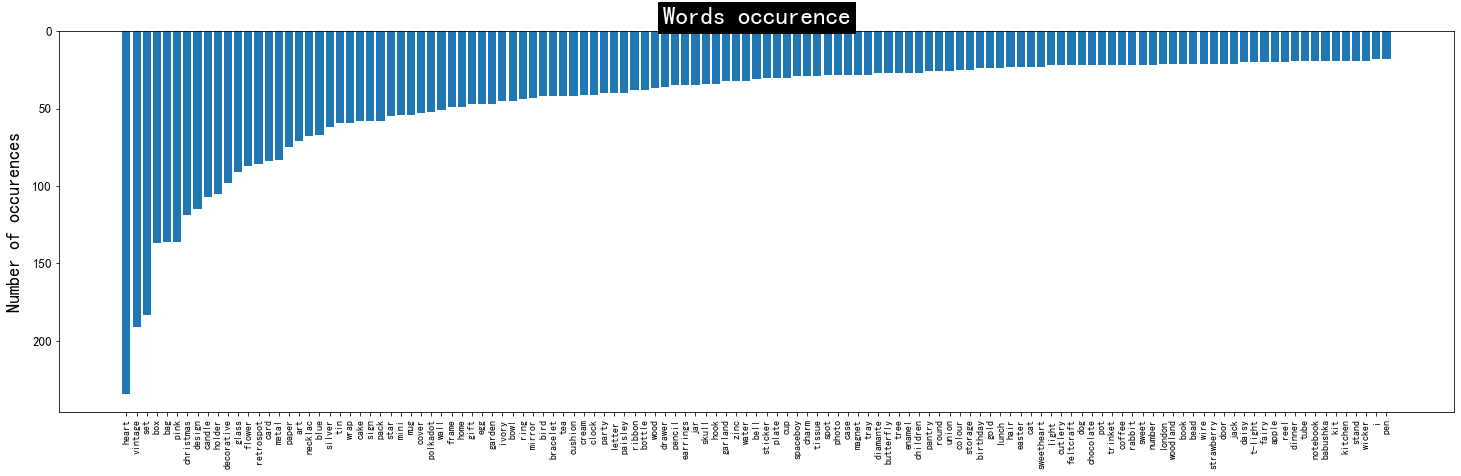

In [31]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)

plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(25, 7))
x_axis = [i[1] for i in liste[:125]]
y_axis = [k for k,i in enumerate(liste[:125])]
y_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 10,rotation=90)
plt.yticks(fontsize = 13)
plt.xticks(y_axis, y_label)
plt.ylabel("Number of occurences", fontsize = 18, labelpad = 10)
ax.bar(y_axis, x_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()

plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

列表中有将近1400个词，最频繁出现的有200多个，有一些关键词像颜色这类的名称无用，因此给其删除，只考虑频数超过15的词。

# 定义产品类别

In [32]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 25: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])

list_products.sort(key = lambda x:x[1], reverse = True)
print('保留字:', len(list_products))

保留字: 82


一共有将近82个词是符合条件的

In [33]:
list_products

[['heart', 234],
 ['vintage', 191],
 ['set', 183],
 ['box', 137],
 ['bag', 136],
 ['christmas', 119],
 ['design', 115],
 ['candle', 107],
 ['holder', 105],
 ['decorative', 98],
 ['glass', 91],
 ['flower', 87],
 ['retrospot', 86],
 ['card', 84],
 ['metal', 83],
 ['paper', 75],
 ['art', 71],
 ['necklac', 68],
 ['silver', 62],
 ['tin', 59],
 ['wrap', 59],
 ['cake', 58],
 ['sign', 58],
 ['pack', 58],
 ['star', 55],
 ['mini', 54],
 ['mug', 54],
 ['cover', 53],
 ['polkadot', 52],
 ['wall', 51],
 ['frame', 49],
 ['home', 49],
 ['gift', 47],
 ['egg', 47],
 ['garden', 47],
 ['ivory', 45],
 ['bowl', 45],
 ['ring', 44],
 ['mirror', 43],
 ['bird', 42],
 ['bracelet', 42],
 ['tea', 42],
 ['cushion', 42],
 ['cream', 41],
 ['clock', 41],
 ['party', 40],
 ['letter', 40],
 ['paisley', 40],
 ['ribbon', 38],
 ['bottle', 38],
 ['wood', 37],
 ['drawer', 36],
 ['pencil', 35],
 ['earrings', 35],
 ['jar', 35],
 ['skull', 34],
 ['hook', 34],
 ['garland', 32],
 ['zinc', 32],
 ['water', 32],
 ['bell', 31],
 ['sti

In [34]:
liste_products=data_describe['描述'].unique()
X=pd.DataFrame()#先创建一个空的列表
for key,values in list_products:
    X.loc[:,key]=list(map(lambda x:int(key.upper() in x),liste_products))
    #选取X列表的每一个key的列，将结果传进去
    #map里面的是在所有描述中寻找和key一样的词，如果有就给其进行计数,再将其变成一个list

In [35]:
X

,heart,vintage,set,box,bag,christmas,design,candle,holder,decorative,...,diamante,butterfly,tree,enamel,children,pantry,round,union,colour,storage
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3292,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3293,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3294,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3295,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


再利用单价对每个产品进行分组，并传入表中

In [36]:
threshold = [0, 1, 2, 4, 8]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_products):
    prix = data[ data['描述'] == prod]['单价'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

In [37]:
X

,heart,vintage,set,box,bag,christmas,design,candle,holder,decorative,...,pantry,round,union,colour,storage,0<.<1,1<.<2,2<.<4,4<.<8,.>8
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3292,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3293,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3294,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3295,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [38]:
print("{:<8} {:<20} \n".format('范围', '产品数量') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

范围       产品数量                 
--------------------
0<.<1       890                 
1<.<2       817                 
2<.<4       800                 
4<.<8       518                 
.>8         272                 


For n_clusters= 2 The average silhouette score is: 0.11231344121944122


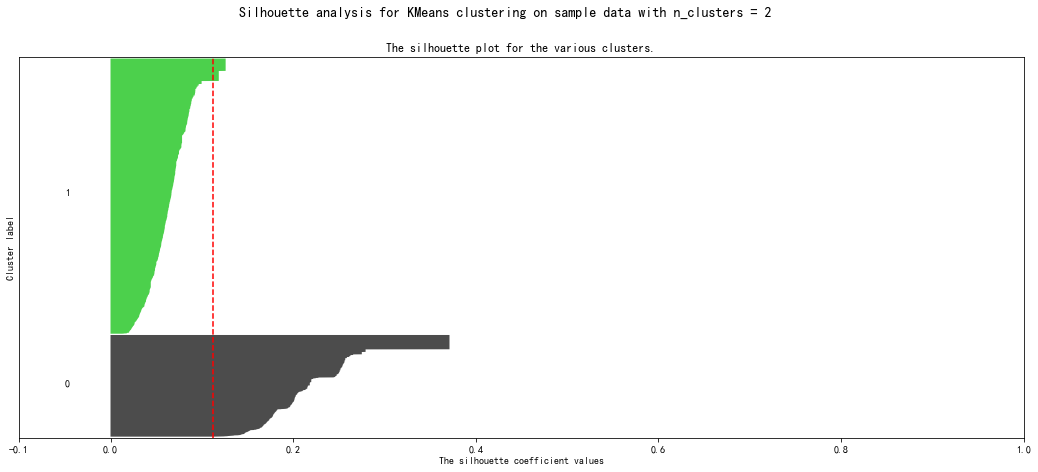

For n_clusters= 3 The average silhouette score is: 0.15020004031258033


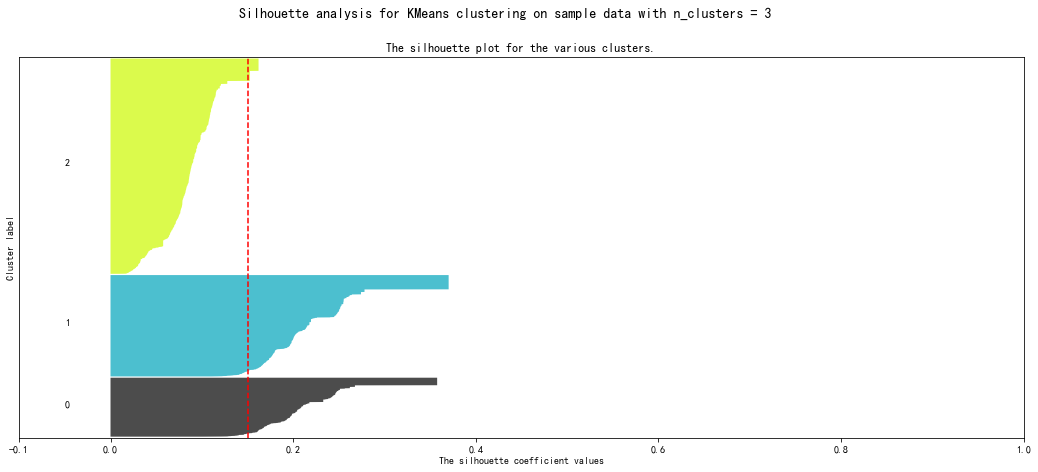

For n_clusters= 4 The average silhouette score is: 0.20035172164762585


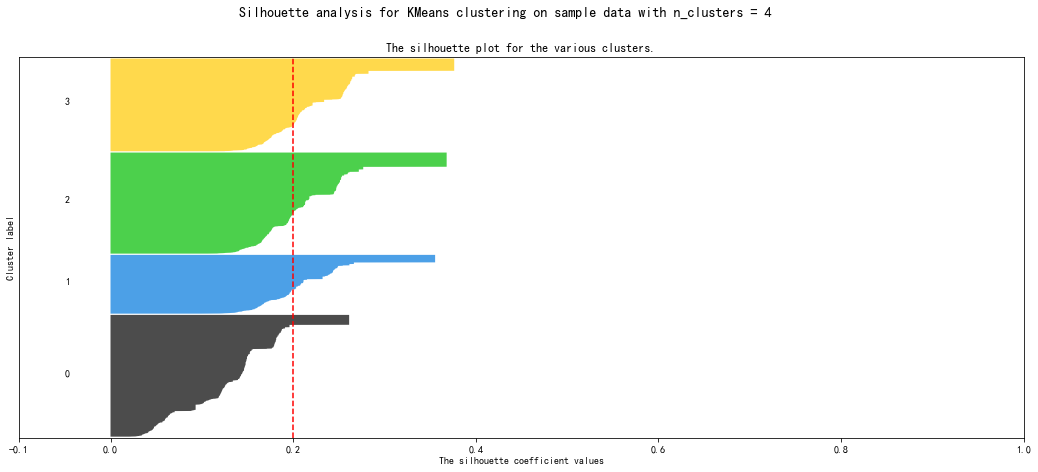

For n_clusters= 5 The average silhouette score is: 0.17480712312784621


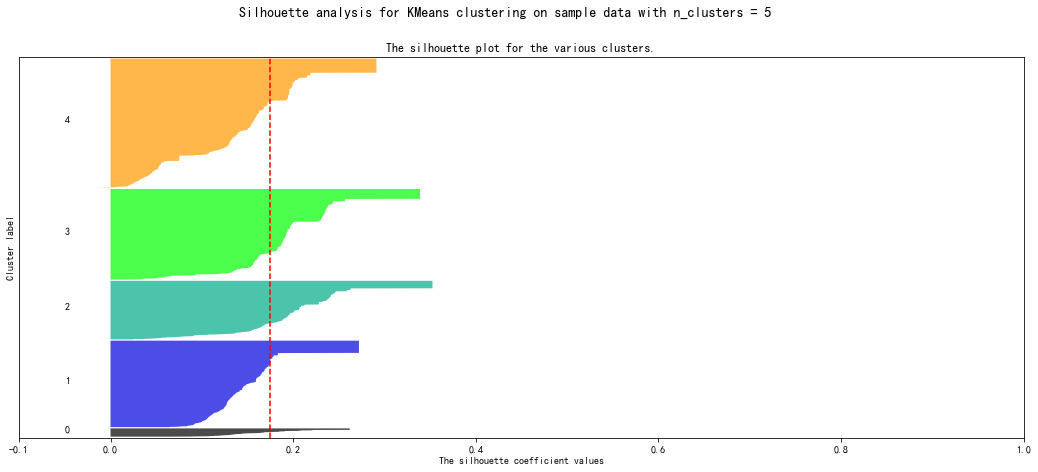

For n_clusters= 6 The average silhouette score is: 0.21980964499125816


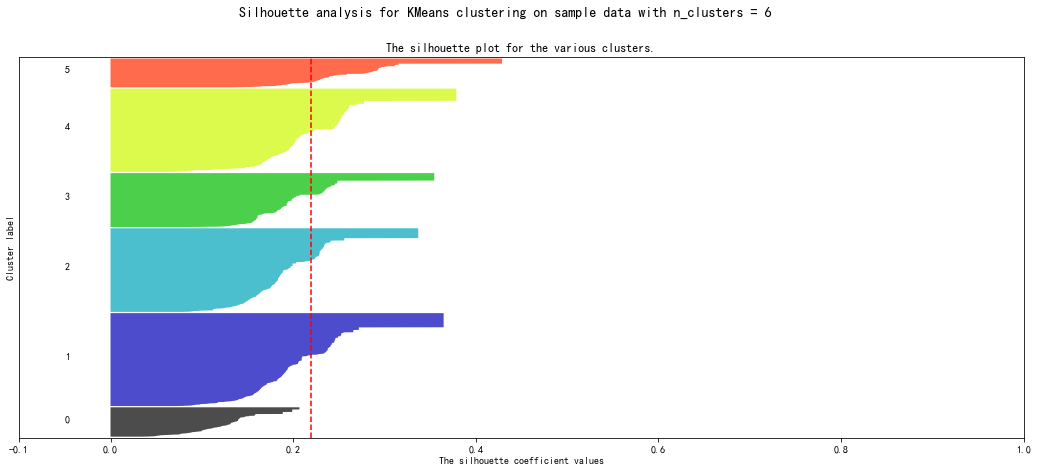

For n_clusters= 7 The average silhouette score is: 0.21402005485934206


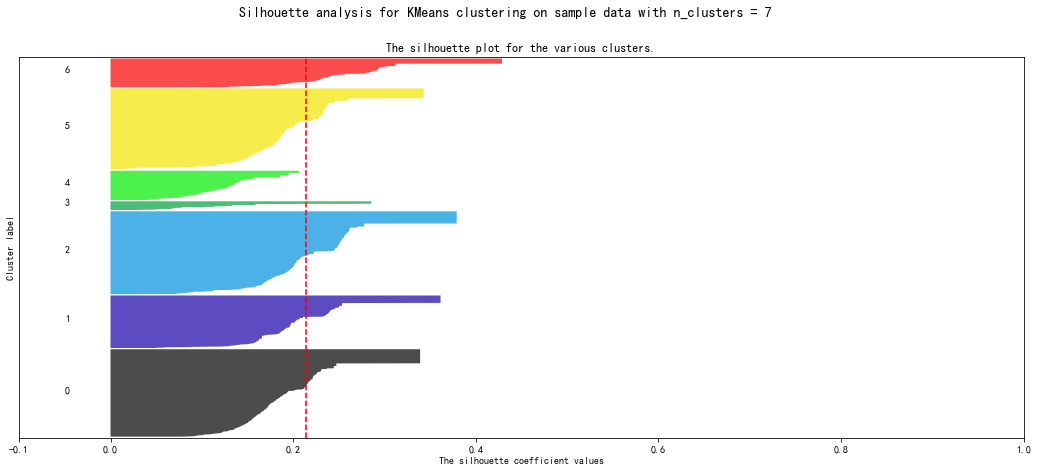

For n_clusters= 8 The average silhouette score is: 0.19991742297531714


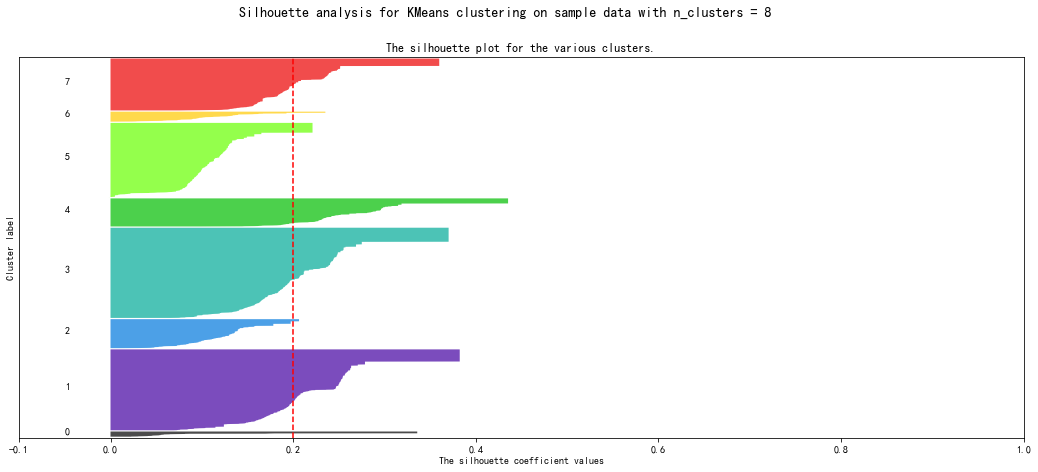

For n_clusters= 9 The average silhouette score is: 0.2084789828096776


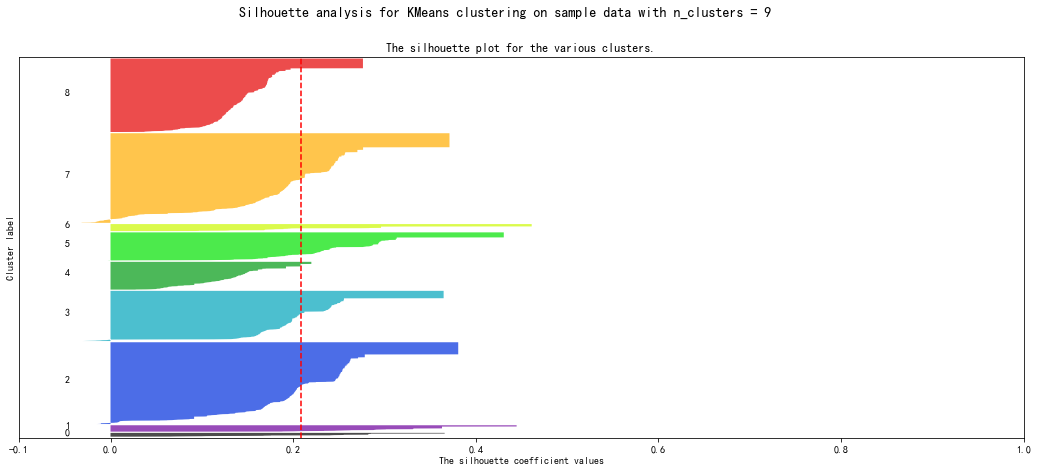

In [39]:
matrix = X.values
for n_clusters in [2,3,4,5,6,7,8,9]:
    n_clusters = n_clusters
    fig,ax1=plt.subplots(1,1)#创建两个子图，一行两列
    fig.set_size_inches(18,7)#调整画布的大小
    ax1.set_xlim([-0.1,1])#设置横坐标
    ax1.set_ylim([0,X.shape[0]+(n_clusters+1)*10])
    clusterer=KMeans(n_clusters=n_clusters,random_state=10).fit(matrix)
    cluster_labels=clusterer.labels_
    silhouette_avg=silhouette_score(X,cluster_labels)#轮廓系数平均值
    print('For n_clusters=',n_clusters,'The average silhouette score is:',silhouette_avg)
    sample_silhouette_values=silhouette_samples(X,cluster_labels)#每个点的轮廓系数
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]#从每个样本的轮廓系数中抽取出第i个簇的轮廓系数，并对其排序
        ith_cluster_silhouette_values.sort()#.sort()直接改变了原数据的顺序
        size_cluster_i = ith_cluster_silhouette_values.shape[0]#查看这个簇中有多少个样本
        y_upper = y_lower + size_cluster_i#簇的上界就是簇的下界加上其样本量
        color = cm.nipy_spectral(float(i)/n_clusters)#用浮点数选择不同的颜色,在nipy_spectral中输入一个小数代表一种颜色
        ax1.fill_betweenx(np.arange(y_lower, y_upper)#fill_between是填充曲线与直角之间的空间的函数，输入的参数应该(纵坐标下限，纵坐标上限，横坐标，颜色)
                         ,ith_cluster_silhouette_values
                         ,facecolor=color
                         ,alpha=0.7)
    
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))#为每个簇写上编号；括号里面是（要显示的横坐标，要显示的纵坐标，要显示的内容）
        y_lower = y_upper + 10
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")#另外在子图上画出一条平均值的线
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    #从第一个图里面可以看出编号为2和3对轮廓系数的贡献度有一半超过平均数，而编号为1的轮廓系数贡献度全部超过平均数
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data ""with n_clusters = %d" % n_clusters),fontsize=14, fontweight='bold')
    plt.show()

通过轮廓系数可以看出类别在4的时候聚类的综合效果最佳

In [40]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.21952557165746447


In [41]:
pd.Series(clusters).value_counts()

0    890
1    817
4    800
2    518
3    272
dtype: int64

可以看出分成的5簇数量差异不是特别大

In [42]:
liste = pd.DataFrame(liste_products)
liste_words = [word for (word, occurence) in list_products]
occurence = [dict() for _ in range(n_clusters)]

#下面将每个词按照对应簇的顺序放进去

In [43]:
clusters#每个词所对应的簇

array([4, 1, 1, ..., 0, 2, 4])

In [44]:
for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']:
            continue
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

定义能绘制词云图函数

In [45]:
def occurence_frequency(occurence):
    plt.figure(figsize=(6,4))
    frequency=[]
    def fuc(key,values):
        i=1
        while i<=values:
            frequency.append(key)
            i+=1
    for key,values in occurence.items():
        fuc(key,values)
    frequency=pd.DataFrame(frequency)
    freq_occur=frequency.groupby(0)[0].count()
    freq_occur=freq_occur.sort_values(ascending=True)
    wordcloud=WordCloud(
                   max_words=100,
                   background_color='white')
    occur_wordcloud=wordcloud.fit_words(freq_occur)
    plt.imshow(occur_wordcloud)
    plt.axis('off')
    plt.show()

绘制每一类的词云图

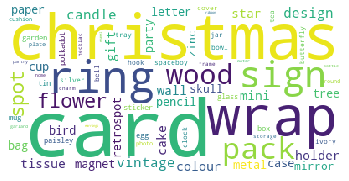

In [46]:
occurence_frequency(occurence[0])

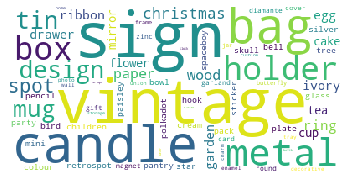

In [47]:
occurence_frequency(occurence[1])

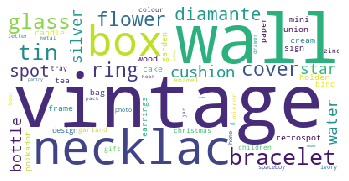

In [48]:
occurence_frequency(occurence[2])

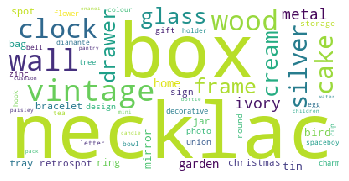

In [49]:
occurence_frequency(occurence[3])

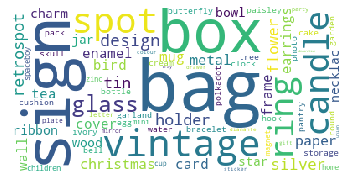

In [50]:
occurence_frequency(occurence[4])

可以看出此时不同的类别包含不同类型的产品，但是每个类别任然含有其他类别的产品，此时我们采用PCA主成分分析，使得聚类的效果能够有效的区分

# PCA主成分分析

首先画一下贡献率曲线

In [51]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

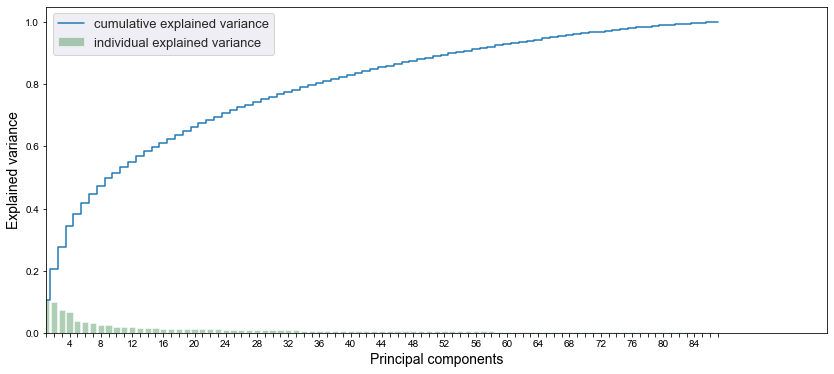

In [54]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%4 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13)

可以看出80个维度数据才能解释超过百分之90的方差，实际选择40左右就行

In [55]:
pca = PCA(n_components=40)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

In [56]:
mat

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,cluster
0,-0.375705,0.720882,-0.282940,-0.061781,-0.093275,0.016784,-0.184409,-0.236699,-0.114029,-0.416319,...,-0.020447,-0.026248,-0.078693,0.074498,0.004578,-0.044057,-0.113617,-0.018955,-0.061135,4
1,-0.422431,-0.649872,-0.314198,-0.191086,-0.124924,-0.152474,-0.176023,0.487433,0.301865,-0.091969,...,0.081415,0.026163,-0.140352,0.120023,0.107402,-0.050923,-0.000417,0.027751,-0.074302,1
2,-0.443781,-0.674166,-0.229303,-0.126298,-0.058151,-0.102476,-0.142127,-0.068118,-0.034753,0.028773,...,-0.017713,0.002034,-0.016840,-0.009238,-0.012491,0.006025,-0.013375,-0.001709,0.004117,1
3,-0.009972,0.025394,0.883754,-0.253790,-0.237827,-0.059759,-0.050492,-0.054025,-0.046002,-0.080672,...,-0.024098,0.160937,0.007072,0.019327,0.107392,0.099011,0.596999,0.293137,-0.250504,2
4,-0.044071,0.026113,0.900258,-0.242633,-0.221405,-0.041168,-0.029613,-0.076748,-0.046406,-0.028208,...,-0.037424,0.083387,-0.010174,0.035966,0.115849,0.153286,0.619195,0.381745,-0.232821,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3292,0.819439,-0.044478,-0.162821,0.000904,-0.100023,-0.087354,-0.195542,-0.196655,-0.023148,-0.283665,...,-0.286573,0.260962,0.054436,-0.030771,-0.397618,-0.056376,0.179631,-0.414160,-0.201306,0
3293,-0.008755,0.002542,0.183781,-0.147440,1.034492,-0.121676,0.061032,-0.022604,-0.085988,0.010834,...,0.014480,0.082908,-0.006764,0.028245,-0.113898,0.067947,-0.030044,-0.075854,-0.041003,3
3294,0.795397,-0.055210,-0.193060,-0.072150,-0.082798,0.023899,-0.138171,-0.200226,-0.105527,-0.449930,...,-0.072866,0.035367,0.057248,0.141043,-0.148515,0.041980,-0.082287,-0.148443,-0.106035,0
3295,-0.054112,0.027193,0.904412,-0.197795,-0.205918,-0.064244,-0.028764,-0.073132,-0.023983,-0.035085,...,-0.024807,0.079179,0.081162,0.021685,-0.140140,0.025842,-0.012102,-0.099625,-0.020801,2


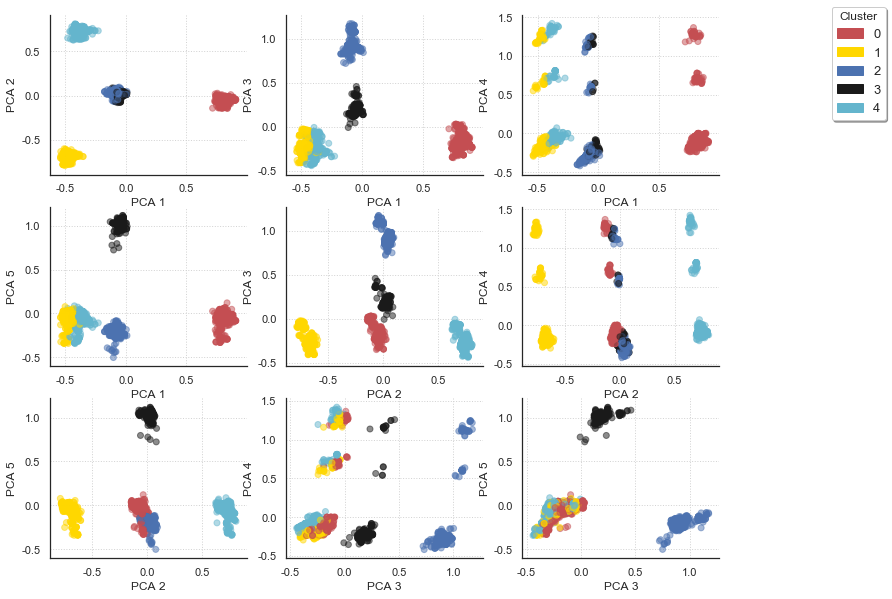

In [57]:
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 5):   
        increment += 1
        ax = fig.add_subplot(3,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', 
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

由上图可以看出第一主成分较好的将几个类别分开了，说明此次降维效果还不错

# 客户分类

首先将产品分类的信息导入数据

In [58]:
data_describe['categ_product']=clusters
data_clean=data.merge(data_describe,left_on='描述',right_on='描述',how='left')
data_clean['订单日期']=pd.to_datetime(data_clean['订单日期'])

In [59]:
data_clean.rename(columns={'categ_product':'产品类别'},inplace= True)
data_clean.head()

,订单编号,库存代码,描述,数量,订单日期,单价,客户ID,总价,产品类别
0,559519,22662,LUNCH BAG DOLLY GIRL DESIGN,150,2011-07-08 16:17:00,1.45,17353.0,217.50,1
1,559519,22383,LUNCH BAG SUKI DESIGN,150,2011-07-08 16:17:00,1.45,17353.0,217.50,1
2,559519,20728,LUNCH BAG CARS BLUE,150,2011-07-08 16:17:00,1.45,17353.0,217.50,1
3,559519,22382,LUNCH BAG SPACEBOY DESIGN,150,2011-07-08 16:17:00,1.45,17353.0,217.50,1
4,559523,23164,REGENCY CAKE SLICE,1,2011-07-08 17:19:00,4.95,13955.0,4.95,2


产品分组处理

In [60]:
for i in range(5):
    col='类别_{}'.format(i)
    data_temp=data_clean[data_clean['产品类别']==i]
    price_temp=data_temp['单价']*data_temp['数量']
    price_temp=price_temp.apply(lambda x:x if x>0 else 0)
    data_clean.loc[:,col]=price_temp
    data_clean[col].fillna(0,inplace=True)
data_clean[['订单编号', '描述', '产品类别', 
            '类别_0', '类别_1', '类别_2', 
            '类别_3','类别_4']][:5]

,订单编号,描述,产品类别,类别_0,类别_1,类别_2,类别_3,类别_4
0,559519,LUNCH BAG DOLLY GIRL DESIGN,1,0.0,217.5,0.00,0.0,0.0
1,559519,LUNCH BAG SUKI DESIGN,1,0.0,217.5,0.00,0.0,0.0
2,559519,LUNCH BAG CARS BLUE,1,0.0,217.5,0.00,0.0,0.0
3,559519,LUNCH BAG SPACEBOY DESIGN,1,0.0,217.5,0.00,0.0,0.0
4,559523,REGENCY CAKE SLICE,2,0.0,0.0,4.95,0.0,0.0


In [61]:
# 购买金额/用户及订单
temp = data_clean.groupby(by=['客户ID', '订单编号'], as_index=False)['总价'].sum()
basket_price = temp.rename(columns = {'总价':'购物车价格'})

# 订单/产品类别价格的百分比
for i in range(5):
    col = '类别_{}'.format(i) 
    temp = data_clean.groupby(by=['客户ID', '订单编号'], as_index=False).sum()[col]
    basket_price.loc[:, col] = temp 

# 订单日期

data_clean['订单日期_int'] = data_clean['订单日期'].astype('int64')
temp = data_clean.groupby(by=['客户ID', '订单编号'], as_index=False)['订单日期_int'].mean()
data_clean.drop('订单日期_int', axis = 1, inplace = True)
basket_price.loc[:, '订单日期'] = pd.to_datetime(temp['订单日期_int'])

# selection of significant entries:
basket_price = basket_price[basket_price['购物车价格'] > 0]
basket_price.sort_values('客户ID', ascending = True)[:5]

,客户ID,订单编号,购物车价格,类别_0,类别_1,类别_2,类别_3,类别_4,订单日期
0,12347.0,562032,584.91,61.30,109.70,102.0,136.05,175.86,2011-08-02 08:48:00
1,12347.0,573511,1294.32,154.30,203.30,168.1,96.40,672.22,2011-10-31 12:25:00
2,12347.0,581180,224.82,58.98,80.40,30.0,0.00,55.44,2011-12-07 15:52:00
3,12348.0,568172,310.00,0.00,270.00,0.0,40.00,0.00,2011-09-25 13:13:00
4,12349.0,577609,1757.55,79.32,465.86,354.2,569.40,288.77,2011-11-21 09:51:00


# RFM模型客户分类

In [62]:
id_class=basket_price[['客户ID','购物车价格','订单日期']]
id_class.head()

,客户ID,购物车价格,订单日期
0,12347.0,584.91,2011-08-02 08:48:00
1,12347.0,1294.32,2011-10-31 12:25:00
2,12347.0,224.82,2011-12-07 15:52:00
3,12348.0,310.00,2011-09-25 13:13:00
4,12349.0,1757.55,2011-11-21 09:51:00


In [63]:
id_class['订单日期']=pd.to_datetime(id_class['订单日期']).dt.floor('d')#dt.floor('')可以转化为某个时间形式
id_class.head()

,客户ID,购物车价格,订单日期
0,12347.0,584.91,2011-08-02
1,12347.0,1294.32,2011-10-31
2,12347.0,224.82,2011-12-07
3,12348.0,310.00,2011-09-25
4,12349.0,1757.55,2011-11-21


In [64]:
id_class.sort_values(by='订单日期')

,客户ID,购物车价格,订单日期
2585,13955.0,117.86,2011-07-08
7873,17353.0,870.00,2011-07-08
7208,16866.0,45.00,2011-07-10
8994,18024.0,337.58,2011-07-10
8620,17787.0,149.02,2011-07-10
...,...,...,...
4980,15311.0,494.60,2011-12-09
3405,14446.0,186.83,2011-12-09
3400,14441.0,305.70,2011-12-09
2741,14051.0,1203.90,2011-12-09


可以看出最后一次的购买的时间是12月9日

In [65]:
df_class=id_class.groupby('客户ID').agg(last_data=('订单日期','max'),
                              F=('订单日期','count'),
                              M=('购物车价格','sum')
                             ).reset_index()

In [66]:
df_class['R']=(pd.to_datetime('2011.12.9')-df_class['last_data']).dt.days

In [67]:
df_class

,客户ID,last_data,F,M,R
0,12347.0,2011-12-07,3,2104.05,2
1,12348.0,2011-09-25,1,310.00,75
2,12349.0,2011-11-21,1,1757.55,18
3,12352.0,2011-11-03,3,944.23,36
4,12356.0,2011-11-17,1,58.35,22
...,...,...,...,...,...
3307,18277.0,2011-10-12,1,110.38,58
3308,18278.0,2011-09-27,1,173.90,73
3309,18282.0,2011-12-02,2,178.05,7
3310,18283.0,2011-12-06,9,1233.49,3


In [68]:
df_class.describe([0.01,0.2,0.4,0.6,0.8,1.0])

,客户ID,F,M,R
count,3312.000000,3312.000000,3312.000000,3312.00000
mean,15282.258454,2.831824,1437.303247,42.48279
std,1722.479062,4.300735,6171.166359,37.74826
min,12347.000000,1.000000,6.200000,0.00000
1%,12405.110000,1.000000,43.593500,0.00000
20%,13489.400000,1.000000,229.884000,9.00000
40%,14690.400000,1.000000,415.928000,22.00000
50%,15276.500000,2.000000,563.655000,30.00000
60%,15860.600000,2.000000,746.876000,42.00000
80%,17057.200000,4.000000,1462.760000,73.00000


实际应用中RFM模型中R、F、M是根据实际的业务情况进行打分的；R是指最近一次消费距离现在的时间，F指消费的频率，M指的是消费的金额

In [69]:
df_class['F'].value_counts()

1      1460
2       724
3       402
4       249
5       126
6        98
7        72
8        48
9        31
11       16
13       14
14       11
12       10
10        9
16        7
15        5
17        4
20        4
18        2
21        2
38        2
24        2
25        1
29        1
30        1
101       1
36        1
41        1
121       1
39        1
40        1
22        1
26        1
19        1
31        1
65        1
Name: F, dtype: int64

In [70]:
df_class['R'].value_counts()

1      103
4       94
3       94
2       90
8       79
      ... 
117      3
152      3
136      2
150      2
154      1
Name: R, Length: 132, dtype: int64

In [71]:
df_class['M'].value_counts()

90.00       3
1070.48     2
347.75      2
408.00      2
2826.51     2
           ..
166.20      1
1072.73     1
20366.63    1
2399.68     1
1072.00     1
Name: M, Length: 3276, dtype: int64

#此次打分我们选择#R等于1打5分，2-10打4分，11-30打3分，31-70打2分，大于70打1分
#F等于1打1分，2打2分，3-4打3分，5-6打4分，大于6打5分
#M在0-200打1分，200-400打2分，400-700打3分，700-1000打4分，大于1000打5分

In [72]:
def fuc_1(x):
    if x==1:
        return 5
    elif x>1 and x<=10:
        return 4
    elif x>10 and x<=30:
        return 3
    elif x>30 and x<=70:
        return 2
    elif x>70:
        return 1
def fuc_2(x):
    if x==1:
        return 1
    elif x==2:
        return 2
    elif x>2 and x<=4:
        return 3
    elif x>4 and x<=6:
        return 4
    elif x>6:
        return 5
def fuc_3(x):
    if x>=0 and x<=200:
        return 1
    elif x>200 and x<=400:
        return 2
    elif x>400 and x<=700:
        return 3
    elif x>700 and x<=1000:
        return 4
    elif x>1000:
        return 5

In [73]:
df_class['R_score']=df_class['R'].apply(fuc_1)
df_class['F_score']=df_class['F'].apply(fuc_2)
df_class['M_score']=df_class['M'].apply(fuc_3)

In [74]:
df_class

,客户ID,last_data,F,M,R,R_score,F_score,M_score
0,12347.0,2011-12-07,3,2104.05,2,4.0,3,5
1,12348.0,2011-09-25,1,310.00,75,1.0,1,2
2,12349.0,2011-11-21,1,1757.55,18,3.0,1,5
3,12352.0,2011-11-03,3,944.23,36,2.0,3,4
4,12356.0,2011-11-17,1,58.35,22,3.0,1,1
...,...,...,...,...,...,...,...,...
3307,18277.0,2011-10-12,1,110.38,58,2.0,1,1
3308,18278.0,2011-09-27,1,173.90,73,1.0,1,1
3309,18282.0,2011-12-02,2,178.05,7,4.0,2,1
3310,18283.0,2011-12-06,9,1233.49,3,4.0,5,5


In [75]:
avg_R=df_class['R_score'].mean()
avg_F=df_class['F_score'].mean()
avg_M=df_class['M_score'].mean()

In [76]:
def fue_1(x):
    if x>=avg_R:
        return 1
    else:
        return 0

def fue_2(x):
    if x>=avg_F:
        return 1
    else:
        return 0

def fue_3(x):
    if x>=avg_M:
        return 1
    else:
        return 0
df_class['R_level']=df_class['R_score'].apply(fue_1)
df_class['F_level']=df_class['F_score'].apply(fue_2)
df_class['M_level']=df_class['M_score'].apply(fue_3)

In [77]:
df_class.head()

,客户ID,last_data,F,M,R,R_score,F_score,M_score,R_level,F_level,M_level
0,12347.0,2011-12-07,3,2104.05,2,4.0,3,5,1,1,1
1,12348.0,2011-09-25,1,310.00,75,1.0,1,2,0,0,0
2,12349.0,2011-11-21,1,1757.55,18,3.0,1,5,1,0,1
3,12352.0,2011-11-03,3,944.23,36,2.0,3,4,0,1,1
4,12356.0,2011-11-17,1,58.35,22,3.0,1,1,1,0,0


In [78]:
df_class['RFM']=df_class['R_level'].astype('str').str.cat([df_class['F_level'].astype('str'),df_class['M_level'].astype('str')])

In [79]:
df_class['RFM']=df_class['RFM'].replace(['111','101','011','001','110','100','010','000'],['重要价值客户','重要发展客户','重要保持客户','重要挽留客户','一般价值客户','一般发展客户','一般保持客户','一般挽留客户'])

In [80]:
df_class

,客户ID,last_data,F,M,R,R_score,F_score,M_score,R_level,F_level,M_level,RFM
0,12347.0,2011-12-07,3,2104.05,2,4.0,3,5,1,1,1,重要价值客户
1,12348.0,2011-09-25,1,310.00,75,1.0,1,2,0,0,0,一般挽留客户
2,12349.0,2011-11-21,1,1757.55,18,3.0,1,5,1,0,1,重要发展客户
3,12352.0,2011-11-03,3,944.23,36,2.0,3,4,0,1,1,重要保持客户
4,12356.0,2011-11-17,1,58.35,22,3.0,1,1,1,0,0,一般发展客户
...,...,...,...,...,...,...,...,...,...,...,...,...
3307,18277.0,2011-10-12,1,110.38,58,2.0,1,1,0,0,0,一般挽留客户
3308,18278.0,2011-09-27,1,173.90,73,1.0,1,1,0,0,0,一般挽留客户
3309,18282.0,2011-12-02,2,178.05,7,4.0,2,1,1,0,0,一般发展客户
3310,18283.0,2011-12-06,9,1233.49,3,4.0,5,5,1,1,1,重要价值客户


In [81]:
df_class=df_class[['客户ID','RFM']]
df_class.rename(columns={'RFM':'客户类型'},inplace=True)

In [82]:
df_class

,客户ID,客户类型
0,12347.0,重要价值客户
1,12348.0,一般挽留客户
2,12349.0,重要发展客户
3,12352.0,重要保持客户
4,12356.0,一般发展客户
...,...,...
3307,18277.0,一般挽留客户
3308,18278.0,一般挽留客户
3309,18282.0,一般发展客户
3310,18283.0,重要价值客户


查看每类客户的类型

In [83]:
df=df_class.groupby('客户类型').agg(用户数=('客户ID','count'))

([<matplotlib.patches.Wedge at 0x1f466ff6588>,
 [Text(0.6978930347358763, 0.9203099000158314, '一般价值客户'),
  Text(0.8471006140230523, 0.7851404649626512, '一般保持客户'),
  Text(1.1425390240613522, 0.16920277331336286, '一般发展客户'),
  Text(0.09083872097841665, -1.1514223060072295, '一般挽留客户'),
  Text(-1.1420529090948222, 0.17245333521870407, '重要价值客户'),
  Text(-0.5793965365207678, 0.9991619755914148, '重要保持客户'),
  Text(-0.2081116600475835, 1.136096182967023, '重要发展客户'),
  Text(0.2872792815068931, 1.1187026478992905, '重要挽留客户')],
 [Text(0.5317280264654295, 0.7011884952501573, '4.0%'),
  Text(0.6454099916366112, 0.5982022590191628, '1.6%'),
  Text(0.8705059230943636, 0.12891639871494312, '17.5%'),
  Text(0.06921045407879363, -0.87727413791027, '34.6%'),
  Text(-0.8701355497865311, 0.1313930173094888, '22.6%'),
  Text(-0.4414449802062993, 0.7612662671172683, '5.9%'),
  Text(-0.15856126479815882, 0.8655970917843985, '5.1%'),
  Text(0.21887945257668043, 0.8523448745899355, '8.7%')])

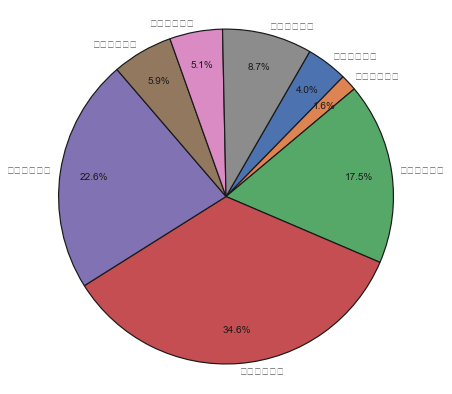

In [84]:
plt.figure(figsize=(7,7))
plt.pie(x=df,autopct='%.1f%%', # 设置百分比的格式，这里保留一位小数
pctdistance=0.8, # 设置百分比标签与圆心的距离
labels= df.index,
labeldistance = 1.05, # 设置标签与圆心的距离
startangle = 60, # 设置饼图的初始角度
radius = 1.1, # 设置饼图的半径
counterclock = False, # 是否逆时针，这里设置为顺时针方向
wedgeprops = {'linewidth': 1.2, 'edgecolor':'k'},# 设置饼图内外边界的属性值
textprops = {'fontsize':10, 'color':'k'}, # 设置文本标签的属性值

)

将客户类别填充到basket_price上

In [85]:
basket_price

,客户ID,订单编号,购物车价格,类别_0,类别_1,类别_2,类别_3,类别_4,订单日期
0,12347.0,562032,584.91,61.30,109.70,102.0,136.05,175.86,2011-08-02 08:48:00
1,12347.0,573511,1294.32,154.30,203.30,168.1,96.40,672.22,2011-10-31 12:25:00
2,12347.0,581180,224.82,58.98,80.40,30.0,0.00,55.44,2011-12-07 15:52:00
3,12348.0,568172,310.00,0.00,270.00,0.0,40.00,0.00,2011-09-25 13:13:00
4,12349.0,577609,1757.55,79.32,465.86,354.2,569.40,288.77,2011-11-21 09:51:00
...,...,...,...,...,...,...,...,...,...
9377,18283.0,578262,307.05,68.04,86.12,0.0,0.00,152.89,2011-11-23 13:27:00
9378,18283.0,579673,220.31,29.65,66.90,0.0,0.00,123.76,2011-11-30 12:59:00
9379,18283.0,580872,208.00,27.07,61.90,0.0,0.00,119.03,2011-12-06 12:02:00
9380,18287.0,570715,1001.32,256.84,386.44,17.0,0.00,341.04,2011-10-12 10:23:00


In [86]:
basket_price=basket_price.merge(df_class,left_on='客户ID',right_on='客户ID',how='left')

In [87]:
basket_price.head()

,客户ID,订单编号,购物车价格,类别_0,类别_1,类别_2,类别_3,类别_4,订单日期,客户类型
0,12347.0,562032,584.91,61.30,109.70,102.0,136.05,175.86,2011-08-02 08:48:00,重要价值客户
1,12347.0,573511,1294.32,154.30,203.30,168.1,96.40,672.22,2011-10-31 12:25:00,重要价值客户
2,12347.0,581180,224.82,58.98,80.40,30.0,0.00,55.44,2011-12-07 15:52:00,重要价值客户
3,12348.0,568172,310.00,0.00,270.00,0.0,40.00,0.00,2011-09-25 13:13:00,一般挽留客户
4,12349.0,577609,1757.55,79.32,465.86,354.2,569.40,288.77,2011-11-21 09:51:00,重要发展客户


重要价值客户，重要保持客户，重要发展客户，重要挽留客户，一般价值客户，一般保持客户，一般发展客户，一般挽留客户分别用0,1,2,3,4,5,6,7来代替

In [88]:
basket_price['客户类型']=basket_price['客户类型'].replace(
    ['重要价值客户','重要保持客户','重要发展客户','重要挽留客户',
     '一般价值客户','一般保持客户','一般发展客户','一般挽留客户'],
[0,1,2,3,4,5,6,7])

In [89]:
basket_price.head()

,客户ID,订单编号,购物车价格,类别_0,类别_1,类别_2,类别_3,类别_4,订单日期,客户类型
0,12347.0,562032,584.91,61.30,109.70,102.0,136.05,175.86,2011-08-02 08:48:00,0
1,12347.0,573511,1294.32,154.30,203.30,168.1,96.40,672.22,2011-10-31 12:25:00,0
2,12347.0,581180,224.82,58.98,80.40,30.0,0.00,55.44,2011-12-07 15:52:00,0
3,12348.0,568172,310.00,0.00,270.00,0.0,40.00,0.00,2011-09-25 13:13:00,7
4,12349.0,577609,1757.55,79.32,465.86,354.2,569.40,288.77,2011-11-21 09:51:00,2


In [90]:
customer_class=basket_price.groupby(by='客户ID').agg(类别0=('类别_0','sum'),
                                      类别1=('类别_1','sum'),
                                      类别2=('类别_2','sum'),
                                      类别3=('类别_3','sum'),
                                      类别4=('类别_4','sum')
                                      ).reset_index()

In [91]:
customer_class['客户类型']=df_class['客户类型'].replace(
    ['重要价值客户','重要保持客户','重要发展客户','重要挽留客户',
     '一般价值客户','一般保持客户','一般发展客户','一般挽留客户'],
[0,1,2,3,4,5,6,7])

In [92]:
customer_class

,客户ID,类别0,类别1,类别2,类别3,类别4,客户类型
0,12347.0,274.58,393.40,300.1,232.45,903.52,0
1,12348.0,0.00,270.00,0.0,40.00,0.00,7
2,12349.0,79.32,465.86,354.2,569.40,288.77,2
3,12352.0,20.80,209.20,234.2,352.70,127.33,1
4,12356.0,0.00,0.00,0.0,58.35,0.00,6
...,...,...,...,...,...,...,...
3307,18277.0,15.46,33.32,49.0,0.00,12.60,7
3308,18278.0,10.20,34.80,96.2,0.00,32.70,7
3309,18282.0,25.60,22.95,16.6,51.00,61.90,6
3310,18283.0,206.33,383.32,26.8,28.45,588.59,0


产品推荐

In [191]:
result_class=customer_class[['客户类型','类别0','类别1','类别2','类别3','类别4']]

In [208]:
result=result_class.groupby(by='客户类型').agg(类别0消费=('类别0','mean')
                                   ,类别1消费=('类别1','mean')
                                   ,类别2消费=('类别2','mean')
                                   ,类别3消费=('类别3','mean')
                                   ,类别4消费=('类别4','mean'))

In [209]:
result

,类别0消费,类别1消费,类别2消费,类别3消费,类别4消费
客户类型,,,,,
0,420.159840,833.241480,682.882733,427.288627,1240.451133
1,282.383768,625.640928,743.353351,709.612320,1079.897526
2,159.019290,314.819822,293.405089,148.422012,442.967456
3,165.373937,311.792613,230.090174,173.506551,968.124251
4,66.993333,139.279545,90.954470,61.163258,137.082348
5,83.009615,124.307115,95.978846,67.659615,131.489808
6,49.411635,81.065473,55.562737,38.047814,92.038090
7,49.088388,80.462066,53.432825,39.358248,86.603374


由上表可以看出所有的产品都可以尽可能的推送给客户类型为0的客户，因为他们带来的平均收益最高，并且产品4适合推荐给任意类型的客户；并且对于所有的客户来说，产品0带来的收益最低，因此可以考虑尽量少推荐而尽量多推荐其他的产品给客户。